### Explanation about example:

Data used refer to Ratio statement indices of Financial services sector companies

Pipeline:
1. from scratch we will check data to impute
2. by threshold we will remove columns that are over them
3. will encoding category and time series columns
4. test three different models of data imputation (Miceforest, BayesianRidge, LinearRegression)
5. check perfomance of each model (just look that model's performance change over each running, so also the check is done seeing if values imputed have sense to the other ones)
6. use model best performed 

## SetUp

In [3]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from io import StringIO
import time
import numpy as np
import threading
import klib # custom library (pip install klib) # EDA analysis

In [4]:
# Make sure pandas version is over or same of 2.1.0 
print(pd.__version__)

2.1.0


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

## Read Dataframe from GDrive

About the dataframe:
- it's available to anyone (just run the cell to get it)
- It's about Ratio Table statements. Especially, it collects all listed European companies about "Financial Services" sector which start by "A" and "B" letters

In [16]:
# Get data from df shared
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File IDs
rt_y_link = '1BeBmlIfq3COpaIidDUm9YYZ_CDiGu-8C' # file code Ratio table
agg_countries_link = '1zWzIP_58rx2c5kys3WkWhG4jHW4tDctu' # file code countries grouping

# Read files using the function
rt_y = read_gdrive_to_df(rt_y_link) # ratio table df with nan values
aggregated_countries = read_gdrive_to_df(agg_countries_link) # table with countries and values weight for each one

In [17]:
# Check columns type
rt_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1046 entries, 567 to 957
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sector                     1046 non-null   object 
 1   Super Sector               1046 non-null   object 
 2   Industry                   1046 non-null   object 
 3   Country                    1046 non-null   object 
 4   Exchange                   1046 non-null   object 
 5   Ticker                     1046 non-null   object 
 6   Company Name               1046 non-null   object 
 7   Currency Sign              1046 non-null   object 
 8   Year                       1046 non-null   int64  
 9   Liabilities to Assets      1033 non-null   float64
 10  Debt to Liabilities        936 non-null    float64
 11  Debt to Equity             941 non-null    float64
 12  InterestExp to EBIT        925 non-null    float64
 13  Return On Equity           1037 non-null   float64
 

In [18]:
# Convert to 'category'
# -- 'category' type will help up in future models
def convert_to_category(df, last_col='Year'):
    
    cols = df.columns.tolist()

    # Find the index of the specified column
    index = cols.index(last_col)

    # Select columns from start to specified column (included)
    cols_to_convert = cols[:index+1]

    # Convert these columns to 'category' type
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    
    return df

rt_y = convert_to_category(rt_y, last_col='Year')

## Data Imputation

Steps will follow:
- Replacing -9.99 (defoult used to sign anomaly data) with nan
- NaN values dataframe check potentially columns to remove (based on custom threshold)
- Define columns to keep
- Skewness
- Encoding
- Test imputation models
- Impute nan values using selected method

## Replace -9.99
-9.99 refers to defoult value setted for anomaly ratio found in columns

**Count -9.99 values in dataset**

In [19]:
def count_value(df, value):    
    total_count = (df == value).sum().sum()
    
    column_counts = (df == value).sum()
    column_totals = df.count()
    
    column_percentages = (column_counts / column_totals) * 100
    
    return total_count, column_percentages

# Call
total_count, column_percentages = count_value(rt_y, -9.99)

In [20]:
total_count

15

In [21]:
# Column percentage contain -9.99
column_percentages

Sector                      0.00
Super Sector                0.00
Industry                    0.00
Country                     0.00
Exchange                    0.00
Ticker                      0.00
Company Name                0.00
Currency Sign               0.00
Year                        0.00
Liabilities to Assets       0.00
Debt to Liabilities         0.00
Debt to Equity              1.59
InterestExp to EBIT         0.00
Return On Equity            0.00
Total_Shareholders_Equity   0.00
Operating Margin            0.00
Capex to EBIT               0.00
D&A aprox to EBITDA         0.00
dtype: float64

**Replace -9.99 with NaN**

In [22]:
def replace_with_nan(df, value_to_replace):
    '''
    -9.99 will be replace with nan
    '''
    return df.replace(value_to_replace, np.nan)

rt_y1 = replace_with_nan(rt_y, -9.99)

In [23]:
# Check if values replaced
total_count, column_percentages = count_value(rt_y1, -9.99)
total_count

0

# Outliers

### Check data distribution

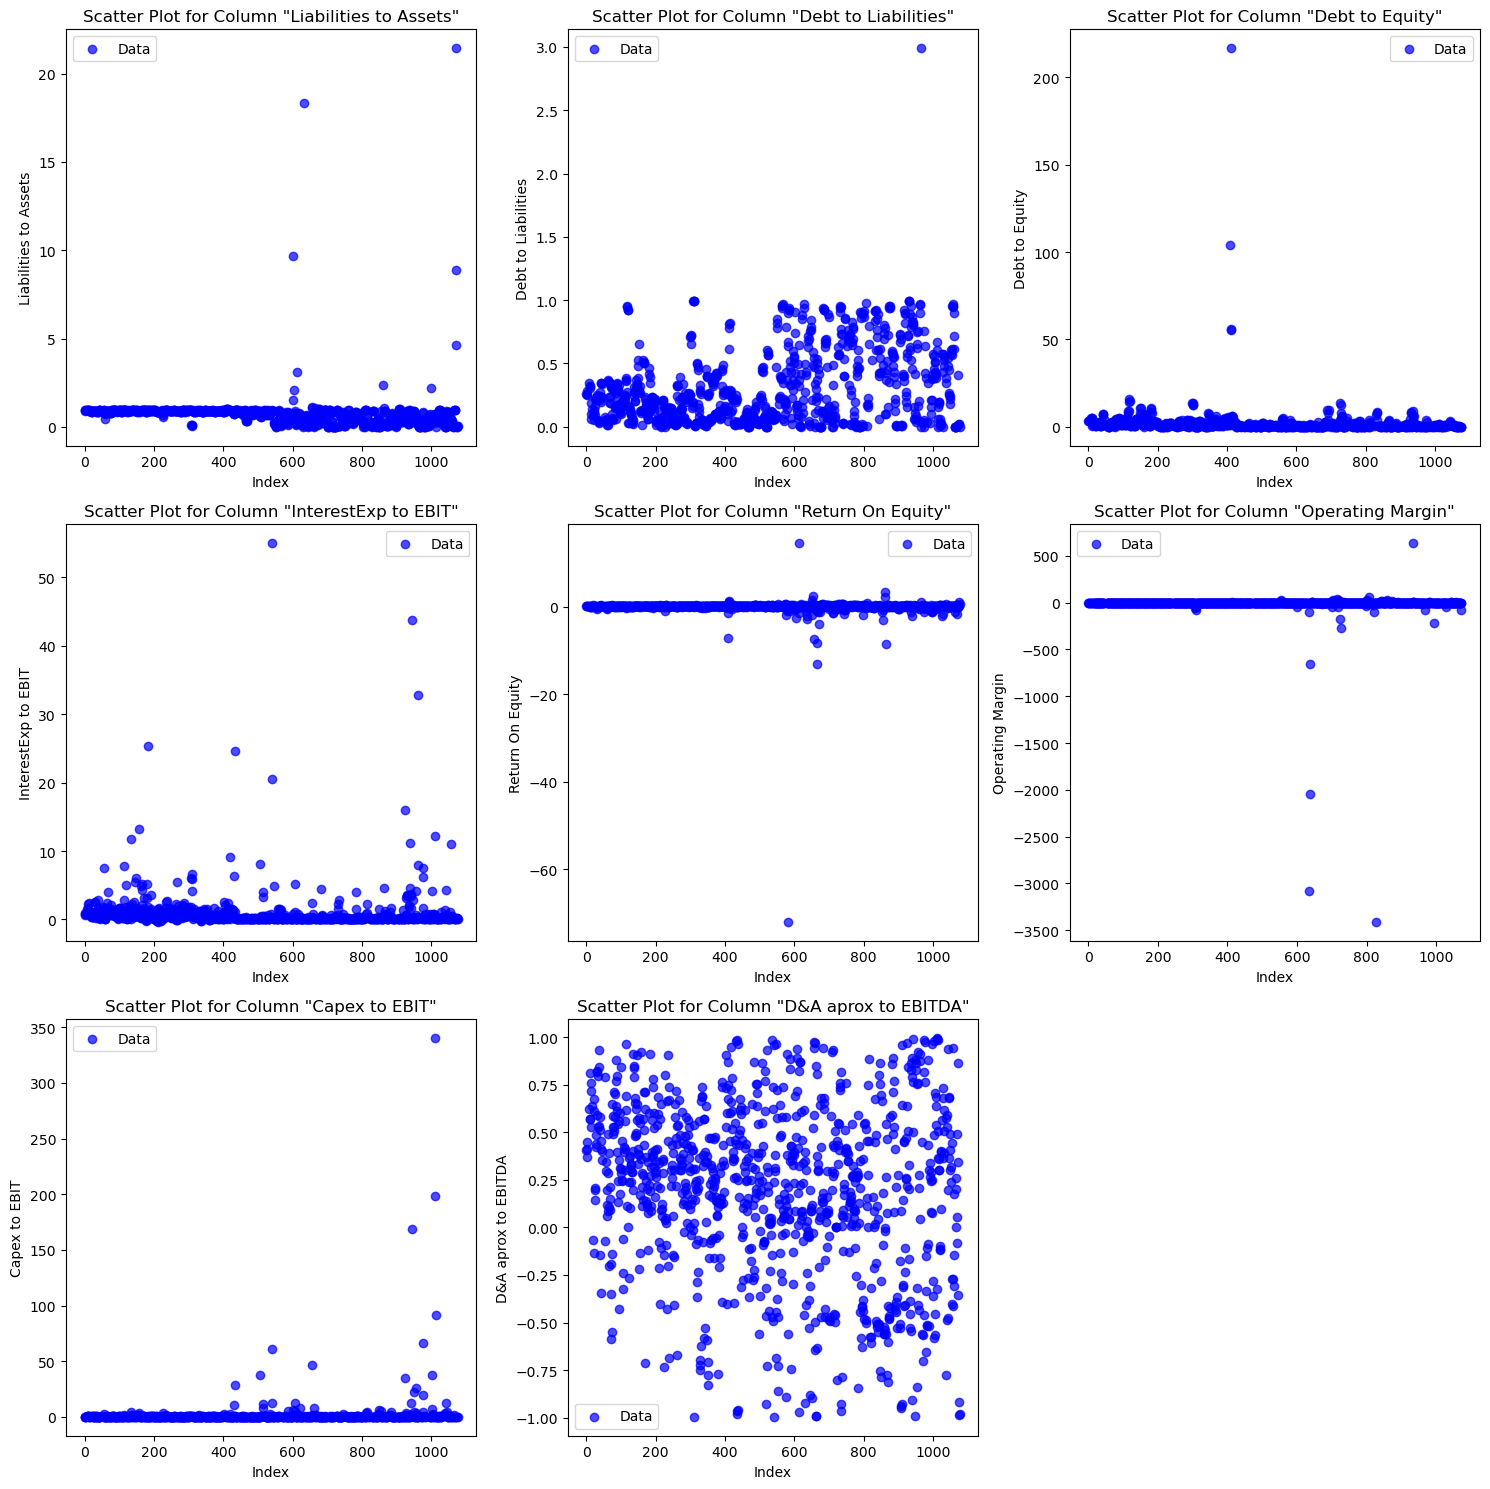

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data_distribution(df, exclude_columns=[], plots_per_row=2):
    df_numeric = df.select_dtypes(include=[np.number])

    # Remove the specified columns from the analysis
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')

    # Extract all columns without the extension "_outlier"
    original_columns = [col for col in df_numeric.columns if not col.endswith('_outlier')]

    # Calculate the number of rows needed
    num_rows = int(np.ceil(len(original_columns) / plots_per_row))
    
    # Initialize the subplots
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))
    
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for idx, column in enumerate(original_columns):
        row = idx // plots_per_row
        col = idx % plots_per_row
        
        # Get the values of the original column
        original_values = df[column]
        
        # Plot the values
        axes[row, col].scatter(original_values.index, original_values, color='b', label='Data', alpha=0.7)
        
        # Add title and legend
        axes[row, col].set_title(f'Scatter Plot for Column "{column}"')
        axes[row, col].set_xlabel('Index')
        axes[row, col].set_ylabel(column)
        axes[row, col].legend()
    
    # Remove any empty plots
    for idx in range(len(original_columns), num_rows * plots_per_row):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.show()

# Call
plot_data_distribution(rt_y1, exclude_columns=['Total_Shareholders_Equity'], plots_per_row=3)

### IsolationForest

this model will be used to check for outliers. The threshold to get X percentage of outliers is setted by "auto" (automated analysis by model), but you can set custom (could use F1 score to get param).

In [30]:
from sklearn.ensemble import IsolationForest

def isolation_forest(df, 
                     exclude_columns=None, 
                     group_column=None, 
                     replace_nan_with_zero=False, 
                     replace_values_with_zero=None, 
                     threshold="auto"):

    if replace_values_with_zero is None:
        replace_values_with_zero = []

    # Convert categorical columns to string columns
    for col in df.select_dtypes(include=['category']).columns:
        df[col] = df[col].astype('str')

    # Replace specified values and NaN with 0, if requested
    if replace_nan_with_zero:
        df = df.fillna(0)
    
    for value in replace_values_with_zero:
        df.replace(value, 0, inplace=True)
    
    if exclude_columns is None:
        exclude_columns = []

    # Select numeric columns, excluding specified columns
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=exclude_columns)

    # Copy of the original dataframe
    df_total_col = df.copy()

    # Number of trees in Isolation Forest
    n_estimators = 100

    # DataFrame to save the predicted columns
    outliers_IsoFor = pd.DataFrame(index=df.index)

    # Create an Isolation Forest object
    isolation_forest = IsolationForest(n_estimators=n_estimators, contamination=threshold, random_state=1991)

    if group_column:
        for group_value, group in df.groupby(group_column):
            for column in df_numeric.columns:
                X = group[column].values.reshape(-1, 1)
                outlier_predictions = isolation_forest.fit_predict(X)

                # Save predictions in the output DataFrame
                outliers_IsoFor.loc[group.index, column + '_outlier'] = outlier_predictions
    else:
        for column in df_numeric.columns:
            X = df[column].values.reshape(-1, 1)
            outlier_predictions = isolation_forest.fit_predict(X)

            # Save predictions in the output DataFrame
            outliers_IsoFor[column + '_outlier'] = outlier_predictions

    # Add the predicted columns to the original dataframe
    df_iso_for = pd.concat([df_total_col, outliers_IsoFor], axis=1)

    return df_iso_for


In [31]:
df_isofor_outliers = isolation_forest(rt_y1, 
                     exclude_columns='Total_Shareholders_Equity', 
                     group_column=None, 
                     replace_nan_with_zero=True, 
                     replace_values_with_zero=None, 
                     threshold="auto")

In [193]:
# df_isofor_outliers

time: 0 ns (started: 2023-09-08 10:17:11 +02:00)


<u>Modelling data to make it more readable

In [32]:
def iso_for_alternate_columns(df, exclude_columns=[]):
    df_category = df.select_dtypes(exclude=[np.number])
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Rimuovere le colonne specificate dall'analisi
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')
    df_category = df_category.drop(columns=exclude_columns, errors='ignore')

    # Round column values with the extension '_outlier' to 0 decimal places
    for col in df_numeric.columns:
        if col.endswith('_outlier'):
            df_numeric[col] = df_numeric[col]

    # Create a blank list to store alternate columns
    alternating_columns = []

    # Extract all columns without the extension "_outlier"
    original_columns = [col for col in df_numeric.columns if not col.endswith('_outlier')]

    # Cycle through the original columns
    for column in original_columns:
        # Aggiungi la colonna originale
        alternating_columns.append(column)

        # Add the corresponding "_outlier" column only if it exists
        outlier_column = column + '_outlier'
        if outlier_column in df.columns:
            alternating_columns.append(outlier_column)

    # Create a new DataFrame using the desired column order
    alternating_df = df[alternating_columns]
    df_iso_for = pd.concat([df_category, alternating_df], axis=1)
    
    def style_outliers(data):
        styles = ['font-weight: bold' if (val == -1 and '_outlier' in col) else '' for val, col in zip(data, data.index)]
        return styles

    # Apply the styling function to the entire DataFrame
    df_iso_for_styled = df_iso_for.style.apply(style_outliers, axis=1)
    display(df_iso_for_styled)

    return df_iso_for

In [34]:
pd.options.display.float_format = '{:.2f}'.format
# df_iso_for = iso_for_alternate_columns(df_isofor_outliers, exclude_columns=['Total_Shareholders_Equity'])

## Outliers analysis

* graph data distribution and outliers hilighted
* bubble graph, formula equal to: total (1) - total (-1). So big bubble contains less outliers
* box plots: check outliers compared to quantile distribution

### Graph data distribution and outliers highlited

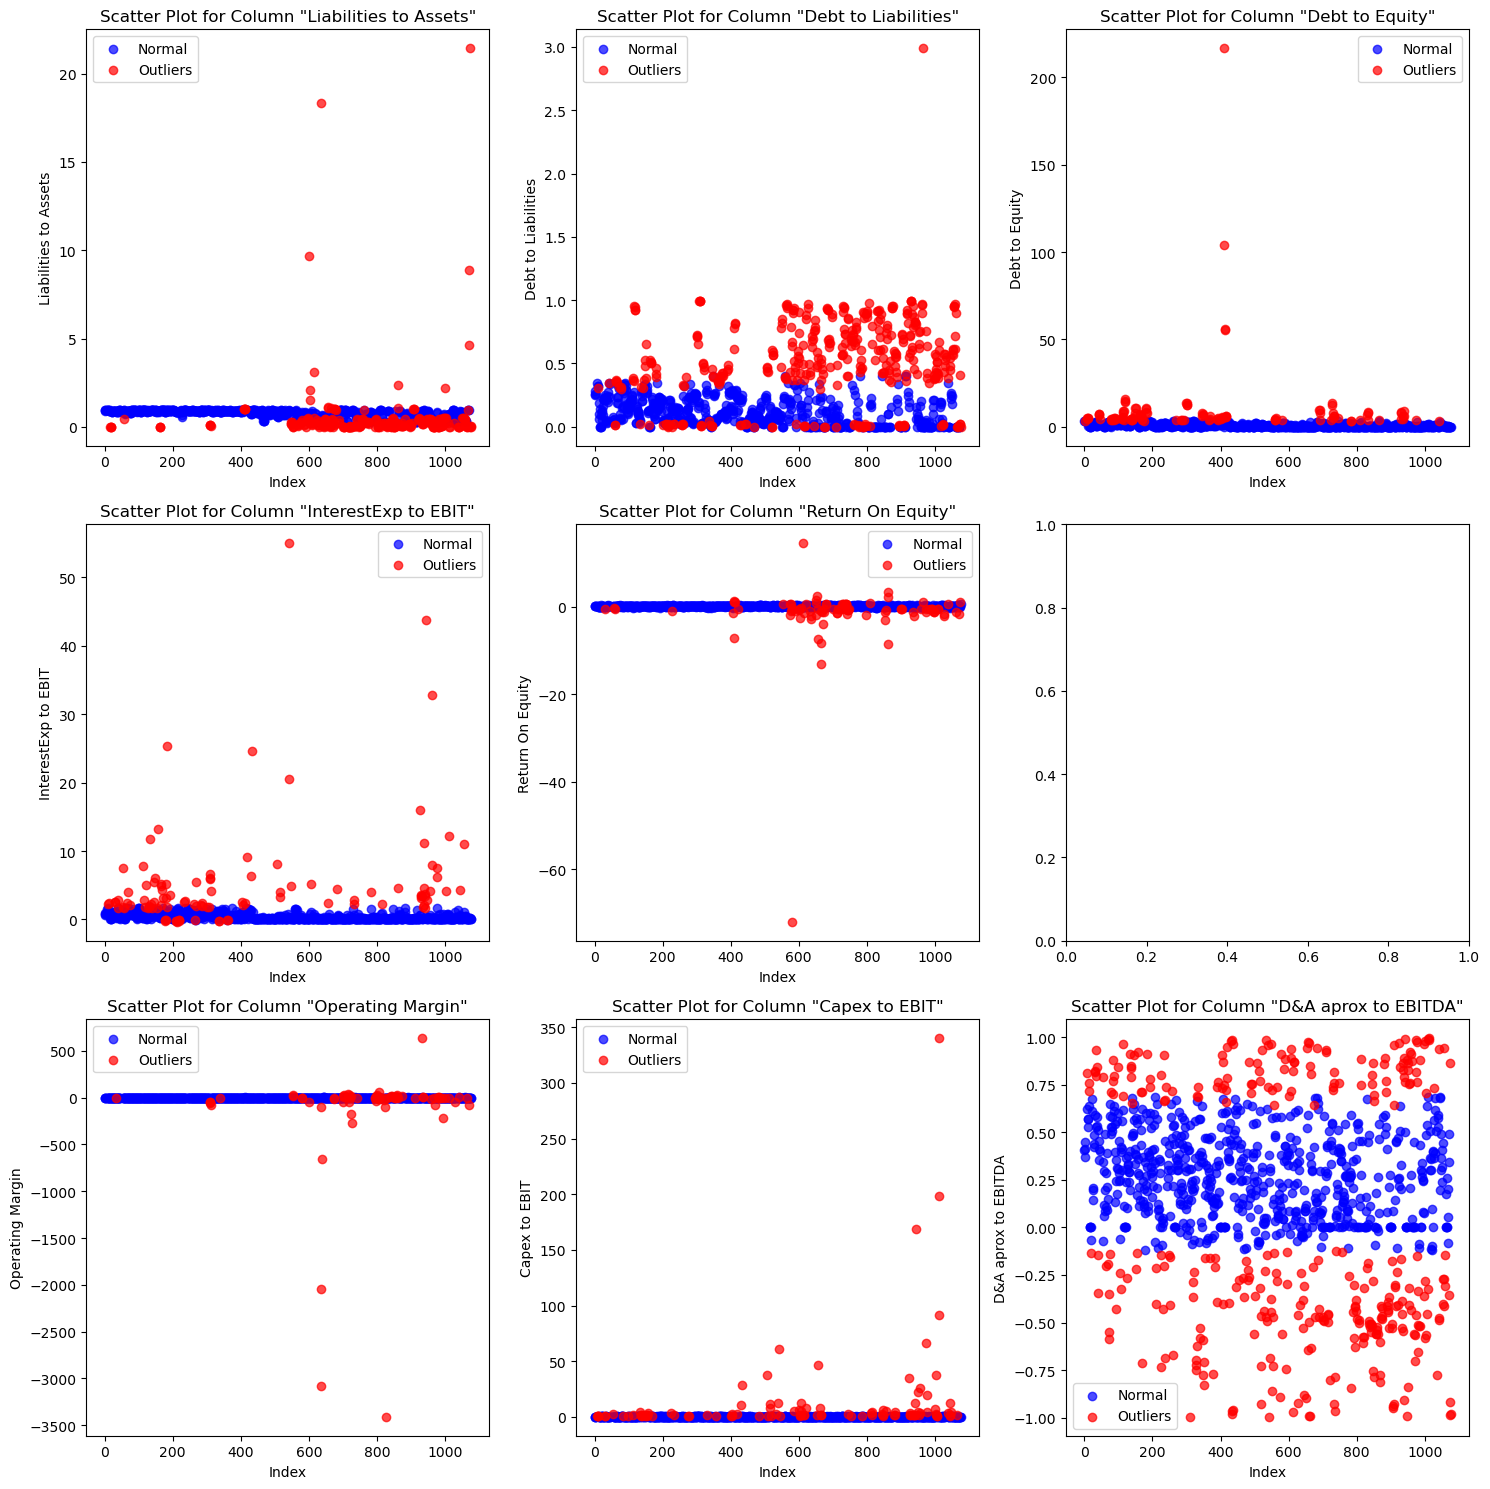

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Graph data distribution and outliers highlighted
def plot_outliers_scatter(df, exclude_columns=[], plots_per_row=2):
    df_numeric = df.select_dtypes(include=[np.number])

    # Remove the specified columns from the analysis
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')

    # Extract all columns without the extension "_outlier"
    original_columns = [col for col in df_numeric.columns if not col.endswith('_outlier')]

    # Calculate the number of rows needed
    num_rows = int(np.ceil(len(original_columns) / plots_per_row))
    
    # Initialize the subplots
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))

    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for idx, column in enumerate(original_columns):
        row = idx // plots_per_row
        col = idx % plots_per_row

        # Check if the corresponding "_outlier" column exists
        outlier_column = column + '_outlier'
        if outlier_column in df.columns:

            #  Get original column and outlier column values
            original_values = df[column]
            outlier_values = df[outlier_column]

            # Mask for values and outliers
            mask_normal = outlier_values == 1
            mask_outliers = outlier_values == -1

            # Plot normal values
            axes[row, col].scatter(original_values[mask_normal].index, original_values[mask_normal], color='b', label='Normal', alpha=0.7)

            # Plots outliers
            axes[row, col].scatter(original_values[mask_outliers].index, original_values[mask_outliers], color='r', label='Outliers', alpha=0.7)

            # Add title and legend
            axes[row, col].set_title(f'Scatter Plot for Column "{column}"')
            axes[row, col].set_xlabel('Index')
            axes[row, col].set_ylabel(column)
            axes[row, col].legend()

    # Remove empty plots
    for idx in range(len(original_columns), num_rows * plots_per_row):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.show()

# Call
plot_outliers_scatter(df_isofor_outliers, exclude_columns=[], plots_per_row=3)

### Show datafram with just outliers

In [36]:
def outliers_df_iso_for(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []
    
    outlier_columns = [col for col in df.columns if col.endswith('_outlier') and col not in exclude_columns]

    # Loop through outlier column indexes
    for col in outlier_columns:
        original_col_idx = df.columns.get_loc(col) - 1 # Index to previous column
        original_col = df.columns[original_col_idx] # Name of previous column

        if original_col not in exclude_columns:
            mask = df[col] == 1 # Create a mask where the values in the outlier column are 1
            df.loc[mask, original_col] = np.nan # Replace the corresponding values in the original column with Nan

    # Copy the dataframe and remove columns with the extension "_outlier"
    df_outlier = df.copy()
    df_outlier = df_outlier.drop(columns=outlier_columns)
    
    return df_outlier

# Call
df_outlier = outliers_df_iso_for(df_iso_for, exclude_columns=[]) # 'Total_Shareholders_Equity' already passed previously

In [38]:
df_outlier.head()

,Sector,Super Sector,Industry,Country,Exchange,Ticker,Company Name,Currency Sign,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2019,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2020,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2021,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,Financial Services,Investment Advisors,Investing/Securities,France,XPAR,ABCA,ABC Arbitrage S.A.,€,2022,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,Financial Services,Investment Advisors,Investing/Securities,Norway,XOSL,ABG,ABG Sundal Collier Holding ASA,kr,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Bubble graph (bigger means more outliers found in column)

Percentage outliers found for each column


Liabilities to Assets   0.26
Debt to Liabilities     0.37
Debt to Equity          0.11
InterestExp to EBIT     0.10
Return On Equity        0.09
Operating Margin        0.07
Capex to EBIT           0.10
D&A aprox to EBITDA     0.34
dtype: float64

Average outliers found: 0.18


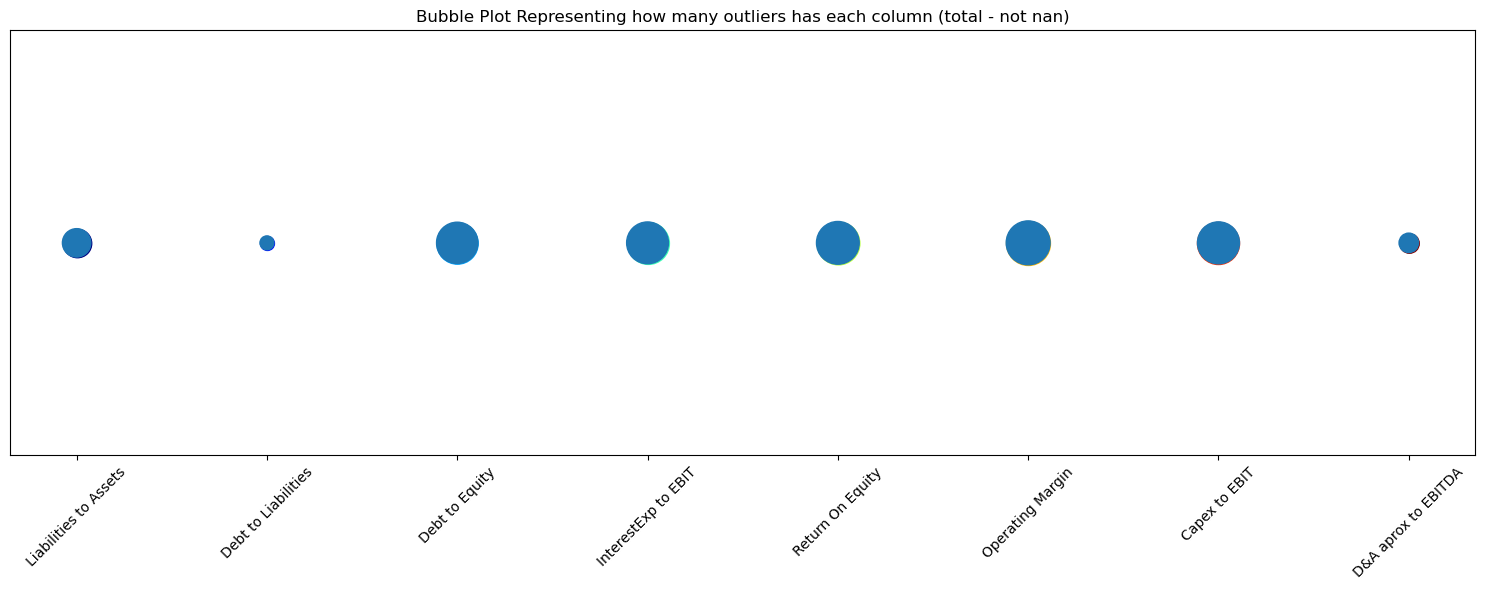

In [39]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def outliers_df_outliers_presence(df, exclude_columns=[]):
    df_numeric = df.select_dtypes(include=[np.number])

    # Remove the specified columns from the analysis
    df_numeric = df_numeric.drop(columns=exclude_columns, errors='ignore')

    # Calculate the size of bubbles
    nan_count = df_numeric.isna().sum()
    not_nan_count = df_numeric.count()
    total_count = nan_count + not_nan_count
    bubble_sizes = total_count - not_nan_count
    
    # --- TABLE
    print('Percentage outliers found for each column')
    fraction_outliers = not_nan_count/total_count
    display(fraction_outliers.round(2))
    
    # Show the overall average
    mean_outliers = fraction_outliers.mean()
    print(f'Average outliers found: {mean_outliers:.2f}')

    # --- PLOT
    # Resize bubble sizes in a specific range (e.g. 100-1000)
    scaler = MinMaxScaler(feature_range=(100, 1000))
    bubble_sizes_scaled = scaler.fit_transform(bubble_sizes.values.reshape(-1, 1))
    
    # Create a Bubble Chart
    plt.figure(figsize=(15, 6))
    colors = plt.cm.jet(np.linspace(0, 1, len(bubble_sizes))) # Color map

    for idx, size in enumerate(bubble_sizes_scaled):
        plt.scatter(idx, 1, s=size, color=colors[idx], label=bubble_sizes.index[idx]) # Bubble with unique color

    # Create graph
    plt.scatter(range(len(bubble_sizes)), [1] * len(bubble_sizes), s=bubble_sizes_scaled)
    plt.xticks(range(len(bubble_sizes)), bubble_sizes.index, rotation=45) Labels for the x axis
    plt.yticks([]) # Removes ticks on the y-axis
    plt.title('Bubble Plot Representing how many outliers has each column (total - not nan)')
    plt.tight_layout() # Ensures Labels are not cut
    plt.show()

# Call
outliers_df_outliers_presence(df_outlier, exclude_columns=[])

### Setting custom outliers threshold based on previous analysis
1. Consider % of average outliers found by "auto" setting and 
2. Check nan % in dataframe
3. Reset threshold if needs

In [40]:
# NaN values sum
to_start_col = rt_y1.columns.get_loc('Year')
rt_y1.iloc[:, to_start_col+1:].isna().sum()/len(rt_y1)

Liabilities to Assets       0.01
Debt to Liabilities         0.11
Debt to Equity              0.11
InterestExp to EBIT         0.12
Return On Equity            0.01
Total_Shareholders_Equity   0.01
Operating Margin            0.03
Capex to EBIT               0.20
D&A aprox to EBITDA         0.06
dtype: float64

In [41]:
df_isofor_outliers1 = isolation_forest(rt_y1, 
                     exclude_columns='Total_Shareholders_Equity', 
                     group_column=None, 
                     replace_nan_with_zero=True, 
                     replace_values_with_zero=None, 
                     threshold=0.03) # reset

In [43]:
# data modelling (column and columns + '_outlier')
# df_iso_for1 = iso_for_alternate_columns(df_isofor_outliers1, exclude_columns=['Total_Shareholders_Equity'])

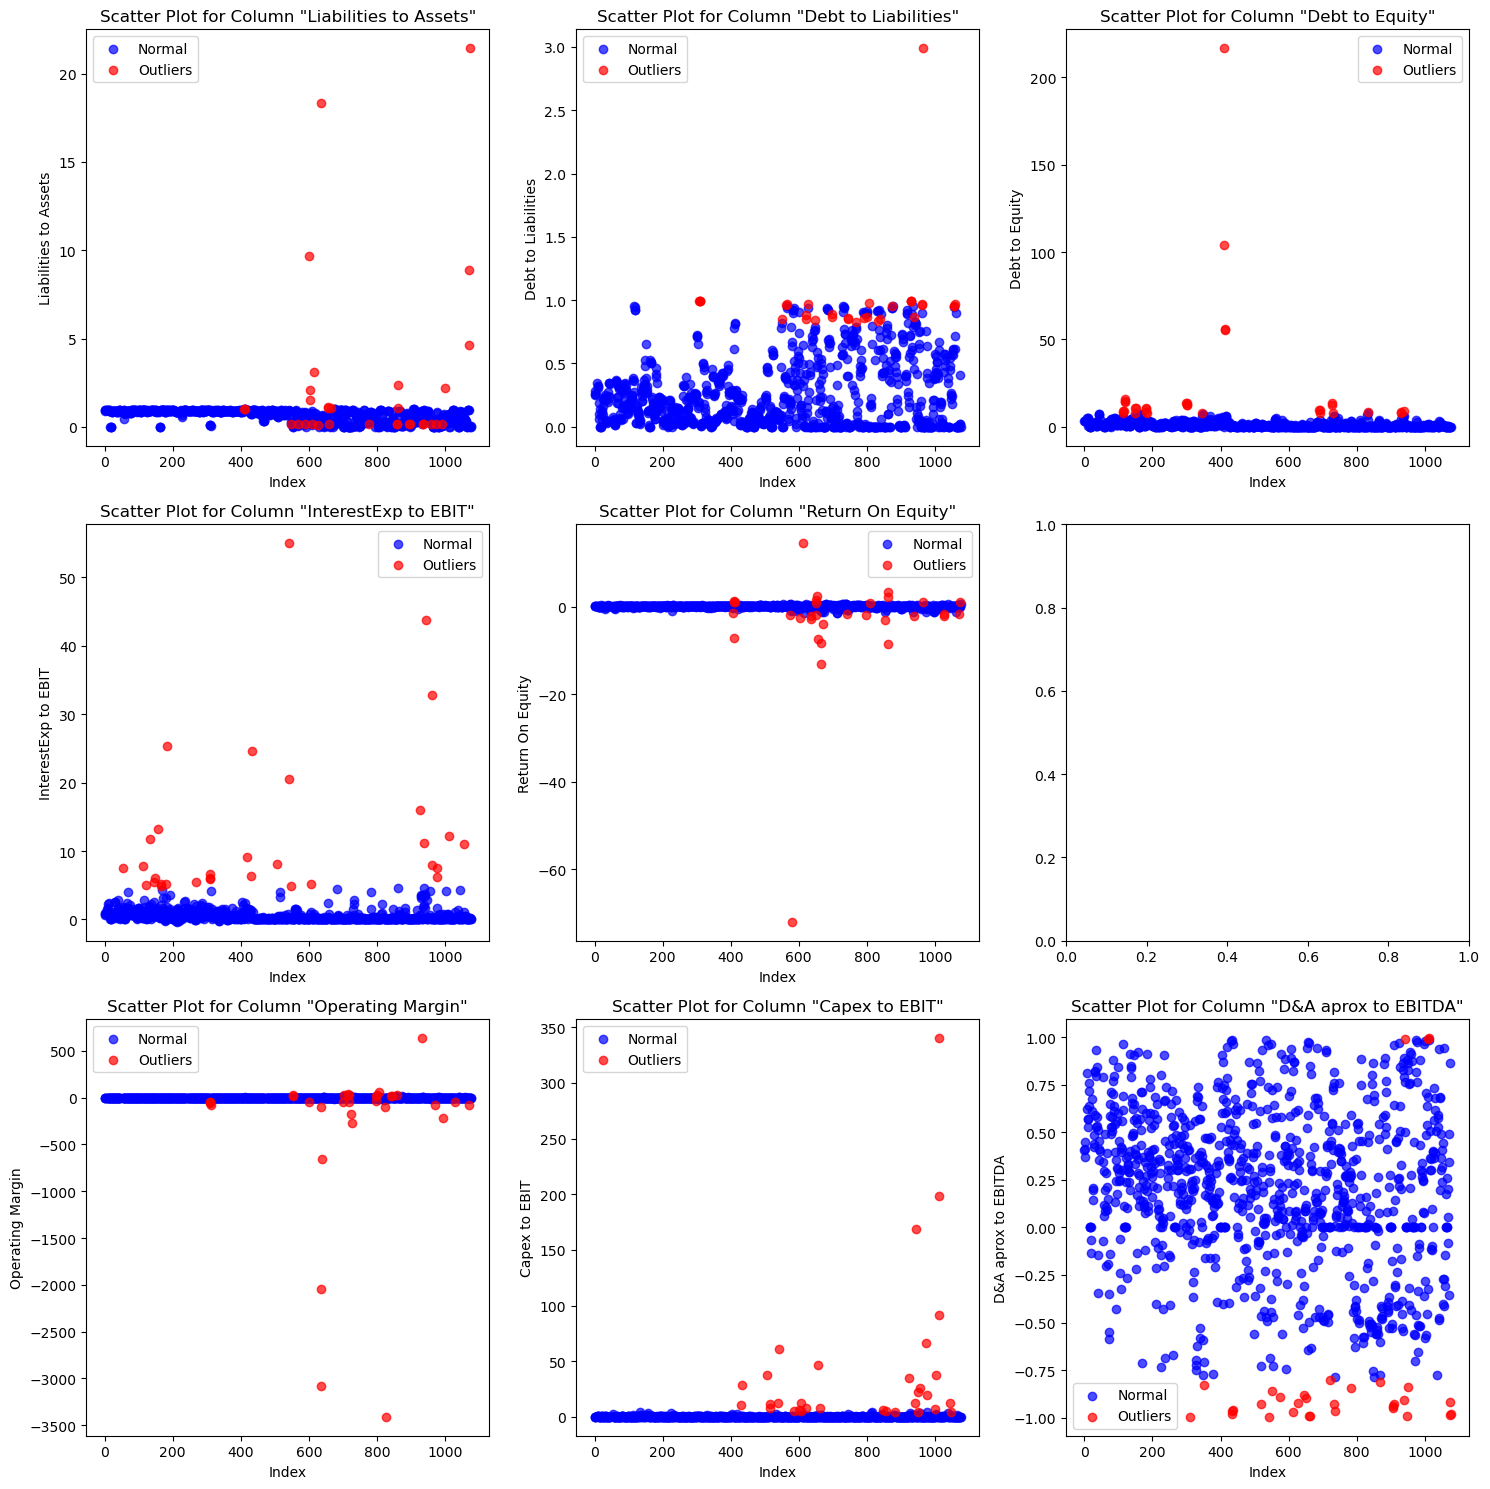

In [44]:
plot_outliers_scatter(df_isofor_outliers1, exclude_columns=[], plots_per_row=3) # call: df_isofor_outliers1 (not the styled)

In [45]:
# Leave just values and replace others with nan
df_outlier1 = outliers_df_iso_for(df_iso_for1, exclude_columns=['Total_Shareholders_Equity'])

box plots: check outliers compared to quantile distribution

Outliers or No Outliers: No Outliers


C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\utente\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will

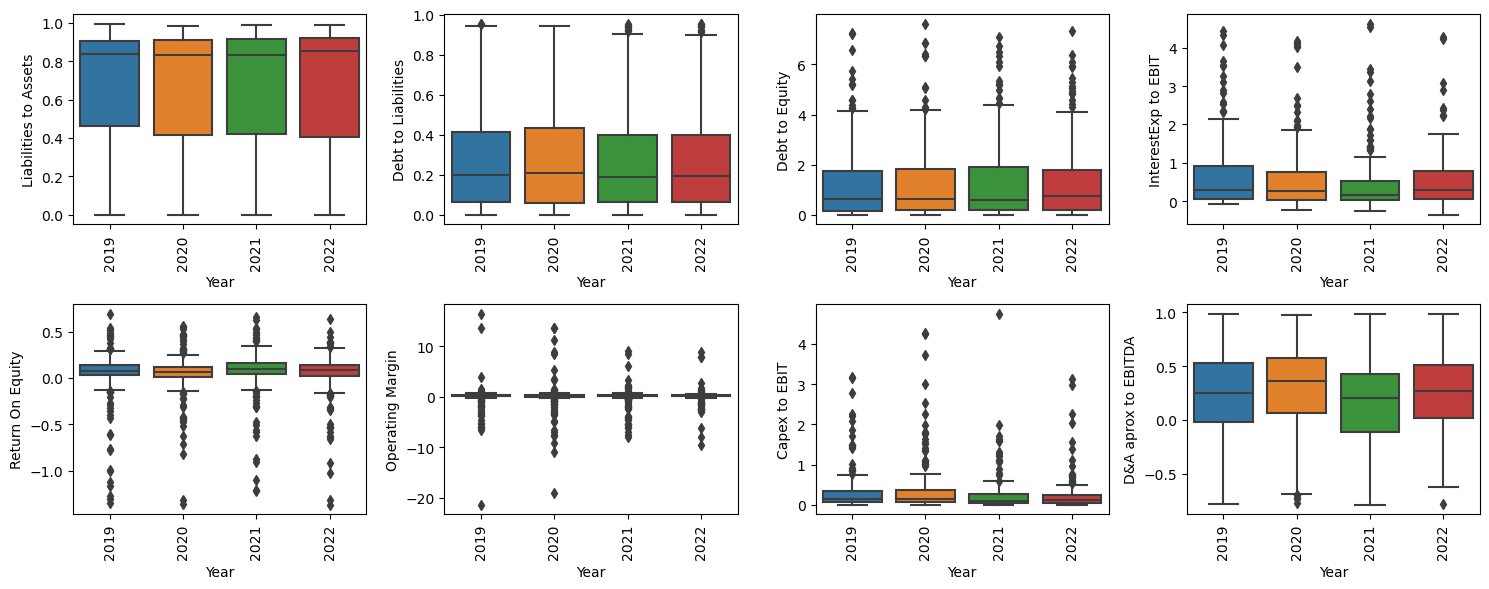

In [46]:
# NOTE, make sure that:
# - 'df_outlier' only contain outliers
# - select df normalized with mean distance by each country

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def Boxplot_DataDistribution(time_column, df, df_outliers, exclude_columns=[]):
    
    df_copy = df.copy()
    df_copy[time_column] = df_copy[time_column].astype('category')
    
    # Option plotting
    selection = None
    while selection not in ['Outliers', 'No Outliers']:
        selection = input('Outliers or No Outliers: ')
        if selection not in ['Outliers', 'No Outliers']:
            print('Try again with options available')
    
    # Remove outliers for 'No Outliers'
    if selection == 'No Outliers':
        mask = df_outliers.select_dtypes(include=[np.number]).notna()
        for col in mask.columns:
            if col in df_copy.columns and col != time_column and col not in exclude_columns:
                df_copy[col] = df_copy[col].where(mask[col] == False)

    
    selected_columns = df_copy.select_dtypes(include=[np.number]).drop(columns=[time_column] + exclude_columns, errors='ignore').columns

    # Select all columns except "year"
    
    n = len(selected_columns)
    ncols = 4
    nrows = math.ceil(n / ncols)  # Calculate the number of rows needed

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3*nrows))  # Increase vertical size based on number of rows

    for i, ax in enumerate(axs.flat):  
        if i < n:  
            x_data = df_copy[time_column]
            y_data = df_copy[selected_columns[i]]

            if x_data.dropna().shape[0] == 0:
                print(f"x_data in column {selected_columns[i]} contains no values")
            if y_data.dropna().shape[0] == 0:
                print(f"y_data in column {selected_columns[i]} contains no values")

            if x_data.dropna().shape[0] > 0 and y_data.dropna().shape[0] > 0:
                sns.boxplot(x=x_data, y=y_data, ax=ax)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            else:
                ax.set_visible(False)
                
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

    return

# Select dataframe which include: Outliers or No Outliers
Boxplot_DataDistribution('Year', rt_y1, df_outlier1, exclude_columns=['Total_Shareholders_Equity'])

## Replace outliers with nan

In [47]:
# make copy of dataframe
rt_y2 = rt_y1.copy()

In [48]:
# threshold setted 0.03 (it will sum up to nan already avaialble on dataset you will pass)

# dataframe passed
to_start_col = rt_y2.columns.get_loc('Year')
rt_y2.iloc[:, to_start_col+1:].isna().sum()/len(rt_y2)

Liabilities to Assets       0.01
Debt to Liabilities         0.11
Debt to Equity              0.11
InterestExp to EBIT         0.12
Return On Equity            0.01
Total_Shareholders_Equity   0.01
Operating Margin            0.03
Capex to EBIT               0.20
D&A aprox to EBITDA         0.06
dtype: float64

In [49]:
# replace to nan in df values found in df_outlier..

def replace_values_with_nan(main_df, outliers_df, exclude_columns=[], include_category=False):

    # Get 'category' column list
    category_columns = main_df.select_dtypes(include=['category']).columns.tolist()
    
    if not include_category:
        exclude_columns = list(set(exclude_columns + category_columns))
    
    # Get the list of numeric columns
    numeric_columns = main_df.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_columns:
        if col not in exclude_columns:
            # Converte la Colonna al tipo di Dati float64
            main_df[col] = main_df[col].astype('float64')
            main_df[col] = main_df[col].where(outliers_df[col].isna(), np.nan)
    
    return main_df

rt_y2 = replace_values_with_nan(rt_y2, df_outlier1, exclude_columns=['Total_Shareholders_Equity'], include_category=False)

In [50]:
# percetage of nan + outliers replaces with nan
to_start_col = rt_y2.columns.get_loc('Year')
rt_y2.iloc[:, to_start_col+1:].isna().sum()/len(rt_y2)

Liabilities to Assets       0.04
Debt to Liabilities         0.14
Debt to Equity              0.15
InterestExp to EBIT         0.15
Return On Equity            0.04
Total_Shareholders_Equity   0.01
Operating Margin            0.06
Capex to EBIT               0.23
D&A aprox to EBITDA         0.09
dtype: float64

### Check NaN

In [51]:
import numpy as np
import pandas as pd
from IPython.display import display

def analyze_nan_values(df, column_filter=None, threshold=0.3):
    """
    Analyze Nan values in DataFrame.
    
    :param df: The DataFrame to analyze
    :param column_filter: The column name to filter through in step b. If None, all numeric columns are parsed. (default=None)
    :param Threshold: The percentage threshold of Nan values to trigger the alert. (default=0.3)
    """
    
    # Step a)
    print('ddc meaning: data, columns, countries\n')
    print('a): Are NaN over specified percentage of total data?')
    total_values = [df.select_dtypes(include=[np.number]).size]
    total_nan_values = [df.isna().sum().sum()]
    percent_nan_values = [total_nan_values[0] / total_values[0] * 100]
    threshold_over = ['Yes' if total_nan_values[0] / total_values[0] > threshold else 'No']
    df_a = pd.DataFrame({'Total values': total_values, 'Total NaN values': total_nan_values, '% NaN values': [f'{x:.0f}%' for x in percent_nan_values], 'Threshold over': threshold_over})
    df_data = display(df_a)

    # Step b)
    print('\nb) Are NaN over specified percentage in some columns?')
    if column_filter:
        numeric_columns = [column_filter]
    else:
        numeric_columns = df.select_dtypes(include=[np.number]).columns

    col_names = []
    total_values_b = []
    total_nan_values_b = []
    percent_nan_values_b = []
    threshold_over_b = []
    for col in numeric_columns:
        col_names.append(col)
        total_values_col = df[col].size
        total_values_b.append(total_values_col)
        nan_values = df[col].isna().sum()
        total_nan_values_b.append(nan_values)
        percent_nan_values_b.append(nan_values / total_values_col * 100)
        threshold_over_b.append('Yes' if nan_values / total_values_col > threshold else 'No')
    
    df_b = pd.DataFrame({'Column name': col_names, 'Total values': total_values_b, 'Total NaN values': total_nan_values_b, '% NaN values': [f'{x:.0f}%' for x in percent_nan_values_b], 'Threshold over': threshold_over_b})
    df_columns = display(df_b)

# Use function:
analyze_nan_values(rt_y2, column_filter=None, threshold=0.3)

ddc meaning: data, columns, countries

a): Are NaN over specified percentage of total data?


,Total values,Total NaN values,% NaN values,Threshold over
0,9414,941,10%,No



b) Are NaN over specified percentage in some columns?


,Column name,Total values,Total NaN values,% NaN values,Threshold over
0,Liabilities to Assets,1046,45,4%,No
1,Debt to Liabilities,1046,142,14%,No
2,Debt to Equity,1046,152,15%,No
3,InterestExp to EBIT,1046,153,15%,No
4,Return On Equity,1046,41,4%,No
5,Total_Shareholders_Equity,1046,9,1%,No
6,Operating Margin,1046,62,6%,No
7,Capex to EBIT,1046,243,23%,No
8,D&A aprox to EBITDA,1046,94,9%,No


## DataImputation

In [52]:
# rt_y copied
rt_y3 = rt_y2.copy()

### Define columns to keep

In [53]:
# Check potentially subgroups which have enough to predict 
rt_y3['Industry'].value_counts()

Industry
Investing/Securities    520
Banking/Credit          418
Insurance               108
Name: count, dtype: int64

In [54]:
def filter_columns(df, keep_columns, start_column):
    # Create a list of columns to keep based on the specified start point
    columns_from_start = df.columns[df.columns.get_loc(start_column):].tolist()
    
    # We merge the two column lists
    final_columns = keep_columns + columns_from_start
    
    # Filter the DataFrame to keep only the desired columns
    return df[final_columns]

In [55]:
rt_y3 = filter_columns(rt_y3, ['Industry', 'Country'], 'Year')
rt_y3 = rt_y3.sort_values(by='Year', ascending=True)

In [91]:
# rt_y3.head()

<!--  -->

## Encoding
- Industry: one hot
- country: label encodig (test because it can influence the predictions)
- year: ordinal encoding

**Upload 'aggregated_countries' df. It will be used to replace Country variables columns**

In [57]:
def read_gdrive_to_df(file_id):
    """
    Read an Excel file from Google Drive using its file ID and return a DataFrame.
    """
    base_url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
    download_url = 'https://drive.google.com/uc?id=' + base_url.split('/')[-2]
    return pd.read_excel(download_url, index_col=0)

# File IDs
aggregated_countries_link = '1t-lU_WfxN2ddB-yLKq2em3A6HGiQcuCj' 

# Read files using the function
aggregated_countries = read_gdrive_to_df(aggregated_countries_link) # mean distance from year for each country

In [58]:
aggregated_countries.sort_values(by='TotPtsQle', ascending=False)

,TotPtsQle,Number,Countries
16,29,1,Germany
15,26,1,Belgium
14,25,1,Netherlands
13,23,1,Switzerland
12,19,3,"Austria, Denmark, Luxembourg"
11,18,1,Malta
10,17,2,"Cyprus, Sweden"
9,16,4,"Greece, Ireland, Italy, Portugal"
8,15,2,"Czechia, Poland"
7,14,4,"France, Hungary, Norway, Spain"


***Encoding steps***

In [59]:
# 1.--- One Hot Encoding per 'industry_name'
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df, column_name, prefix=None):

    if prefix is None:
        prefix = column_name

    df = pd.concat([df, pd.get_dummies(df[column_name], prefix=prefix)], axis=1)
    df.drop(column_name, axis=1, inplace=True)
    
    # List of one-hot columns created
    one_hot_columns = [col for col in df.columns if prefix in col and col != column_name]
    
    # Replace true and false with 0 and 1
    for col in one_hot_columns:
        df[col] = df[col].astype(int)
    
    return df

rt_y3 = one_hot_encode(rt_y3, 'Industry', 'Industry')

In [60]:
# 2.--- Countries: inizialize disct to map (!! this approach can be change leaving just countries instead of values)
country_mapping = {}

# Populating of the mapping dictionary
for index, row in aggregated_countries.iterrows():
    countries = row['Countries'].split(", ")
    for country in countries:
        country_mapping[country] = row['TotPtsQle']

# Map values in the rt_y1 'Country' column using the dictionary
rt_y3['Country'] = rt_y3['Country'].map(country_mapping)

In [61]:
# 3.--- Ordinal Encoding per 'Year'
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# If they are not, you can specify the order with the 'categories' parameter of the OrdinalEncoder
def ordinal_encode(df, column_name):

    oe = OrdinalEncoder(categories=[sorted(df[column_name].unique())])
    df[column_name] = oe.fit_transform(df[[column_name]]).astype(int)
    
    return df, oe

rt_y3, oe = ordinal_encode(rt_y3, 'Year')

In [62]:
# --- Order columns (one hot col first)
# List cols one hot
one_hot_columns = [col for col in rt_y3.columns if "Industry_" in col]

# Column order: first one-hot columns, then the others
new_column_order = one_hot_columns + [col for col in rt_y3.columns if col not in one_hot_columns]

# Rearrange the DataFrame columns in the new order
rt_y3 = rt_y3[new_column_order]

In [63]:
# Check df encoded
rt_y3.head()

,Industry_Banking/Credit,Industry_Insurance,Industry_Investing/Securities,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,0,0,1,14,0,0.04,0.35,0.02,0.00,0.13,1.00,0.49,NaN,0.09
78,1,0,0,16,0,0.93,0.32,4.13,0.59,0.07,1.00,0.17,0.20,0.49
873,0,0,1,17,0,0.04,0.94,0.04,0.00,0.27,1.00,1.00,NaN,-0.46
426,1,0,0,14,0,0.85,0.04,0.24,1.24,0.49,1.00,0.25,0.08,-0.40
881,0,0,1,17,0,0.47,0.60,0.52,1.15,0.01,1.00,0.01,1.41,0.86


<!--  -->

## Imputation Models Testing

In [65]:
# copy df
rt_y4 = rt_y3.copy()

<!--  -->

### Test MICE model

In [767]:
# Install libraries need
# pip install miceforest
# pip install miceforest --upgrade
# pip install git+https://github.com/AnotherSamWilson/miceforest.git # (if miceforest previous install does not work)
# pip install dask --upgrade
# pip install lightgbm --upgrade

time: 0 ns (started: 2023-09-02 23:00:01 +02:00)


In [66]:
# Miceforest (MICE)
import miceforest as mf
from miceforest import ImputationKernel

In [67]:
# test one: made by all data
from sklearn.metrics import mean_squared_error

def mice_imputation_test(df, col_to_test = 'HICP(%)', cols_to_category=['geo', 'country', 'year']):
    
    
    '''  
    Impute need:
    
    Select original dataframe (with nan values)
    
    1) Select df with original values
    1) Select columns to test. That values will be randomly converted to nan and tested with predictions
    2) All nan values predicted will be compared with real
    
    Note: Make sure you don't have empty values in category columns selected
    
    =================
    
    Output:
    
    - kds: imputed data
    - imputed_df: dataframe imputed
    - comparison_df: dataframe with true values and imputed values
    - rmse: Root Mean Squared Error (RMSE) is calculated between the real and imputed values.
    
    '''
    
    global imputed_df, comparison_df, percentage_error_mice, rmse_mice, kds
    
    # If columns are not category yet, convert them
    df_mf = df.copy()
    df_mf[cols_to_category] = df_mf[cols_to_category].astype('category')
    
    # Create a copy of the DataFrame and select a fraction of the known data to be imputed
    df_mf = df.dropna(subset=[col_to_test]).copy()
    true_values = df_mf.sample(frac=0.1)[col_to_test]
    df_mf.loc[true_values.index, col_to_test] = np.nan
    
    # --- MICE model creating
    kds = mf.ImputationKernel(df_mf, random_state=42)
    
    # --- Tuning parameters
    optimal_parameters, losses = kds.tune_parameters(dataset=0, optimization_steps=20)
    kds.mice(1, variable_parameters=optimal_parameters)
    # print(optimal_parameters)
    # ---
    
    # --- Manual setting
    # n_estimators, are number of tree. So, define it considering how mauch data your df contains
    # kds.mice(iterations=20, n_estimators=10, device='gpu') # verbose=2

    # --- Complete the imputed data
    imputed_df = kds.complete_data()

    # Recovers the imputed values
    imputed_values = imputed_df.loc[true_values.index, col_to_test]

    # --- Calculate the RMSE
    rmse_mice = np.sqrt(mean_squared_error(true_values, imputed_values))

    # Calculate the percentage error
    range_of_data = df[col_to_test].max() - df[col_to_test].min()
    percentage_error_mice = (rmse_mice / range_of_data) * 100
    
    print(f'RMSE percentage_error (min,max): {percentage_error_mice:.2f}')
    print(f'RMSE: {rmse_mice:.2f}')

    # --- Create a DataFrame with real and imputed values
    comparison_df = pd.DataFrame({
        'True Values': true_values,
        'Imputed Values': ['{:.2f}'.format(value) for value in imputed_values]
    })
    
    display(comparison_df)

    return 

In [68]:
mice_imputation_test(rt_y4, col_to_test = 'Return On Equity',
                 cols_to_category=['Industry_Banking/Credit', 'Industry_Insurance',
                                   'Industry_Investing/Securities', 'Country', 'Year'])

RMSE percentage_error (min,max): 8.81
RMSE: 0.18


,True Values,Imputed Values
69,0.15,0.02
767,0.12,0.11
958,-0.44,-0.62
979,0.05,0.29
1,0.06,0.04
993,-1.01,0.11
173,0.09,0.12
580,-0.71,-0.62
779,0.31,0.23
959,-0.02,0.07


In [928]:
# Plot compare the distribution by data and data with imputation
# kds.plot_imputed_distributions(wspace=0.3,hspace=0.5)

time: 16 ms (started: 2023-09-03 13:07:05 +02:00)


<!--  -->

### Test skelearn models

In [69]:
#- sklearn imputation libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge

In [73]:
def iterative_imputation_sklearn(df, estimator_choice='BayesianRidge', col_to_test = 'HICP(%)', grouping_col = 'geo'):
    
    '''
    Impute missing values using iterative imputer.
    
    Parameters:
    - df: DataFrame
    - estimator_choice: Either 'BayesianRidge' or 'LinearRegression'
    
    Returns:
    imputed_df, comparison_df, rmse
    '''
    
    global imputed_df, comparison_df, percentage_error_sklearn, rmse_sklearn
    
    # Check estimator choice
    if estimator_choice not in ['BayesianRidge', 'LinearRegression']:
        raise ValueError("estimator_choice must be either 'BayesianRidge' or 'LinearRegression'")

    # Select column to check
    
    true_values_list = []
    imputed_values_list = []
    categorical_values_list = []

    # If grouping_col is specified, group by that column, otherwise use the entire dataframe as a single group.
    if grouping_col:
        groups = df.groupby(grouping_col)
    else:
        groups = [df] # Wrap the dataframe in a list to make it compatible with the rest of the code
    
    # Model used
    print('BayesianRidge model')

    # Define a function to impute missing values within each group
    def impute_group(group):
        subset_group = group.dropna(subset=[col_to_test]).copy()
        true_values = subset_group.sample(frac=0.1)[col_to_test]
        subset_group.loc[true_values.index, col_to_test] = np.nan
        numerical_columns = subset_group.select_dtypes(include=[np.number]).columns
        
        # -- model decided to use in udf setting
        if estimator_choice == 'BayesianRidge':
            imp = IterativeImputer(estimator=BayesianRidge(), max_iter=30, random_state=0)
        else:
            imp = IterativeImputer(estimator=LinearRegression(), max_iter=30, random_state=0)
            
        subset_group[numerical_columns] = imp.fit_transform(subset_group[numerical_columns])
        
        categorical_columns = subset_group.select_dtypes(exclude=[np.number]).columns
        # --
        
        for idx in true_values.index:
            true_values_list.append(true_values[idx])
            imputed_values_list.append(subset_group.loc[idx, col_to_test])
            categorical_values_list.append(group.loc[idx, categorical_columns])

        return subset_group

    # Apply the imputation function
    if grouping_col:
        imputed_df = groups.apply(impute_group).reset_index(drop=True)
    else:
        imputed_df = impute_group(df)
    
    # -- df comparing values
    comparison_df = pd.DataFrame({
        **pd.DataFrame(categorical_values_list),
        'True Values': true_values_list,
        'Imputed Values': ['{:.2f}'.format(value) for value in imputed_values_list]
    })
    
    # -- Evaluate model
    rmse_sklearn = np.sqrt(mean_squared_error(true_values_list, imputed_values_list))
    range_of_data = df[col_to_test].max() - df[col_to_test].min()
    percentage_error_sklearn = (rmse_sklearn / range_of_data) * 100
    
    print(f'MEAN true values: {np.mean(true_values_list):.2f}')
    print(f'MEAN imputed values: {np.mean(imputed_values_list):.2f}')
    print(f'RMSE percentage_error (min,max): {percentage_error_sklearn:.2f}')
    print(f'RMSE: {rmse_sklearn:.2f}')
    
    display(comparison_df)

    return

In [71]:
# BayesianRidge
iterative_imputation_sklearn(rt_y4, estimator_choice='BayesianRidge', col_to_test = 'Return On Equity', grouping_col = None)

BayesianRidge model
MEAN true values: 0.08
MEAN imputed values: 0.05
RMSE percentage_error (min,max): 6.38
RMSE: 0.13


,True Values,Imputed Values
0,0.01,-0.12
1,0.04,0.04
2,0.23,0.03
3,0.49,0.17
4,0.04,0.05
5,-0.05,-0.06
6,0.13,0.14
7,0.10,0.06
8,0.09,0.24
9,0.06,0.08


In [72]:
# Name variable
percentage_error_sklearn_Bayesian = percentage_error_sklearn
rmse_sklearn_Bayesian = rmse_sklearn

In [74]:
# LinearRegression (before running it, run once again the model)
iterative_imputation_sklearn(rt_y1, estimator_choice='LinearRegression', col_to_test = 'Return On Equity', grouping_col = None)

BayesianRidge model
MEAN true values: -0.10
MEAN imputed values: -0.01
RMSE percentage_error (min,max): 1.26
RMSE: 1.09


C:\Users\utente\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Sector,Super Sector,Industry,Country,Exchange,Ticker,Company Name,Currency Sign,Year,True Values,Imputed Values
515,Financial Services,Full-Line Insurance,Insurance,Cyprus,XCYS,MINE,Minerva Insurance Co. Public Ltd.,€,2020,0.02,0.08
171,Financial Services,Banking,Banking/Credit,Spain,XMAD,CABK,CaixaBank S.A.,€,2022,0.08,0.04
888,Financial Services,Investment Advisors,Investing/Securities,Italy,XMIL,INT,Intermonte Partners SIM S.p.A.,€,2022,0.13,-0.04
217,Financial Services,Banking,Banking/Credit,Denmark,XCSE,GRLA,Groenlandsbanken A/S,kr,2020,0.08,0.07
144,Financial Services,Banking,Banking/Credit,Germany,XFRA,BRE,Banco Bradesco S/A Pref,€,2019,0.17,0.02
491,Financial Services,Full-Line Insurance,Insurance,Italy,XMIL,G,Assicurazioni Generali S.p.A.,€,2020,0.06,0.14
39,Financial Services,Banking,Banking/Credit,Germany,XFRA,AKB2,Akbank T.A.S. ADR,€,2020,0.10,0.06
350,Financial Services,Banking,Banking/Credit,Norway,XOSL,NISB,Nidaros Sparebank,kr,2019,0.02,-0.10
665,Financial Services,Securities,Investing/Securities,Sweden,XSTO,ARCA,Arcario AB,kr,2020,-13.04,-2.70
675,Financial Services,Securities,Investing/Securities,Sweden,XSTO,AZA,Avanza Bank Holding AB,kr,2019,0.23,0.15


In [75]:
# Name variable
percentage_error_sklearn_Linear = percentage_error_sklearn
rmse_sklearn_Linear = rmse_sklearn

In [76]:
# Print models RMSE percentage_error (min,max) and RMSE

print('All imputation model tested results\n')
print('MICE')
print(f'RMSE percentage_error (min,max): {percentage_error_mice:.2f}')
print(f'RMSE: {rmse_mice:.2f}')
print('='*15)

print('BayesianRidge')
print(f"RMSE percentage_error (min,max): {percentage_error_sklearn_Bayesian:.2f}")
print(f'RMSE: {rmse_sklearn_Bayesian:.2f}')
print('='*15)

print('LinearRegression')
print(f"RMSE percentage_error (min,max): {percentage_error_sklearn_Linear:.2f}")
print(f'RMSE: {rmse_sklearn_Linear:.2f}')

print('\nNOTE: random seed is not implemented. So, outputs can change running from scratch the model. Make decision considering also some random tests.')

All imputation model tested results

MICE
RMSE percentage_error (min,max): 8.81
RMSE: 0.18
BayesianRidge
RMSE percentage_error (min,max): 6.38
RMSE: 0.13
LinearRegression
RMSE percentage_error (min,max): 1.26
RMSE: 1.09

NOTE: random seed is not implemented. So, outputs can change running from scratch the model. Make decision considering also some random tests.


<!--  -->

### Impute nan values with: BayesianRidge

In [77]:
rt_y4_imputed = rt_y4.copy()

In [78]:
# Before imputation
rt_y4_imputed.isna().sum().sum()

941

In [79]:
# Model definition to imputing nan values
def iterative_imputation_sklearn_all_df(df, estimator_choice='BayesianRidge', col_to_test = 'HICP(%)', grouping_col = 'geo', highlight_imputed=False):
    
    global imputed_df, comparison_df, percentage_error_sklearn, rmse_sklearn, imputed_coordinates, coordinates_df, imputed_values_list, styles # true_values_list
    
    if estimator_choice not in ['BayesianRidge', 'LinearRegression']:
        raise ValueError("estimator_choice must be either 'BayesianRidge' or 'LinearRegression'")

    true_values_list = []
    imputed_values_list = []
    categorical_values_list = []

    if grouping_col:
        groups = df.groupby(grouping_col)
    else:
        groups = [df] # Wrap the dataframe in a list to make it compatible with the rest of the code
    
    print(f'Model used: {estimator_choice}\n')
    
    # Initialize the list and collect NaN coordinates
    imputed_coordinates = []
    for col in df.columns:
        if df[col].isna().any():
            for index in df[df[col].isna()].index:
                imputed_coordinates.append((col, index))
    
    # Create an empty dictionary to store coordinates
    coordinates_dict = {}

    for col, index in imputed_coordinates:
        if col not in coordinates_dict:
            coordinates_dict[col] = []
        coordinates_dict[col].append(index)

    # Convert dictionary to a DataFrame
    coordinates_df = pd.DataFrame.from_dict(coordinates_dict, orient='index').transpose()

    # Fill in the Missing Values with 9.99 caused by mismatched length values imputed on columns
    coordinates_df.fillna(9.99, inplace=True)

    def impute_group(group):
        subset_group = group.dropna(subset=[col_to_test]).copy()
    
        if subset_group.empty:
            return group

        true_values = subset_group.sample(frac=0.1)[col_to_test]
        true_values_list.extend(true_values)
        
        numerical_columns = group.select_dtypes(include=[np.number]).columns
        
        if estimator_choice == 'BayesianRidge':
            imp = IterativeImputer(estimator=BayesianRidge(), max_iter=30, random_state=0)
        else:
            imp = IterativeImputer(estimator=LinearRegression(), max_iter=30, random_state=0)
        
        group[numerical_columns] = imp.fit_transform(group[numerical_columns])
                
        imputed_values_for_true = group.loc[true_values.index, col_to_test]
        imputed_values_list.extend(imputed_values_for_true)

        return group

    # Apply the imputation function
    if grouping_col:
        imputed_df = groups.apply(impute_group).reset_index(drop=True)
    else:
        imputed_df = impute_group(df)
    
    # -- df comparing values
    comparison_df = pd.DataFrame({
        **pd.DataFrame(categorical_values_list),
#         'True Values': true_values_list,
        'Imputed Values': ['{:.2f}'.format(value) for value in imputed_values_list]
    })
    
    # -- Evaluate model
    if not true_values_list or not imputed_values_list:
        print("One or both lists are empty!")
        return
    
    rmse_sklearn = np.sqrt(mean_squared_error(true_values_list, imputed_values_list))
    range_of_data = df[col_to_test].max() - df[col_to_test].min()
    percentage_error_sklearn = (rmse_sklearn / range_of_data) * 100
    
    print('To print dataframe with index imputed variable is: "coordinates_df" (values 9.99 are just to make df equal rows)')
    
    display(comparison_df)
    
    if highlight_imputed:
        def highlight_cells(data):
            # Create a default 'no highlight' style for all cells
            styles = pd.DataFrame('', index=data.index, columns=data.columns)

            # For each coordinate in the imputed_coordinates, set the background color
            for col, row in imputed_coordinates:
                styles.at[row, col] = 'background-color: yellow'
            return styles
        
        display(imputed_df.style.apply(highlight_cells, axis=None))

    return

In [80]:
# BayesianRidge
iterative_imputation_sklearn_all_df(rt_y4_imputed, estimator_choice='BayesianRidge', col_to_test = 'Return On Equity', grouping_col = None, highlight_imputed=True)

Model used: BayesianRidge

To print dataframe with index imputed variable is: "coordinates_df" (values 9.99 are just to make df equal rows)


,Imputed Values
0,0.16
1,0.06
2,0.13
3,0.10
4,0.10
5,0.13
6,0.04
7,0.48
8,0.11
9,0.15


,Industry_Banking/Credit,Industry_Insurance,Industry_Investing/Securities,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,0.000000,0.000000,1.000000,14.000000,0.000000,0.044072,0.347287,0.016011,0.001907,0.131094,1.000000,0.485101,0.299175,0.093327
78,1.000000,0.000000,0.000000,16.000000,0.000000,0.928819,0.316726,4.132885,0.590753,0.066863,1.000000,0.169594,0.197376,0.489356
873,0.000000,0.000000,1.000000,17.000000,0.000000,0.038287,0.935268,0.037235,0.001069,0.265174,1.000000,0.995013,0.151920,-0.464580
426,1.000000,0.000000,0.000000,14.000000,0.000000,0.852473,0.041919,0.242192,1.242835,0.486431,1.000000,0.252606,0.083780,-0.396847
881,0.000000,0.000000,1.000000,17.000000,0.000000,0.466899,0.596335,0.522281,1.152542,0.008465,1.000000,0.009645,1.406780,0.859857
288,1.000000,0.000000,0.000000,14.000000,0.000000,0.838983,0.027239,0.142522,0.967073,0.072653,1.000000,0.155842,0.194834,0.439768
148,1.000000,0.000000,0.000000,16.000000,0.000000,0.951743,0.526761,3.045232,0.716808,0.164634,1.000000,0.301891,0.086094,0.330581
885,0.000000,0.000000,1.000000,16.000000,0.000000,0.730136,0.576807,1.560589,0.219489,0.078761,1.000000,0.261117,0.614002,0.711439
272,1.000000,0.000000,0.000000,29.000000,0.000000,0.913599,0.135522,1.432990,1.111394,0.122083,1.000000,0.305160,0.088029,0.353727
390,1.000000,0.000000,0.000000,16.000000,0.000000,0.909953,0.443714,4.578792,0.249789,0.045015,1.000000,0.175478,0.052405,0.735373


In [611]:
# Dataframe explained for each column index where nan has been replaces
# coordinates_df.sort_values(by=['Liabilities to Assets'], ascending=True)

time: 0 ns (started: 2023-09-08 20:13:31 +02:00)


In [81]:
# Sum tot nan after imputation
rt_y4_imputed.isna().sum().sum()

0

<!--  -->

## Decoding

<!--  -->

In [82]:
# Copy imputed df
rt_y1_pred = rt_y4_imputed.copy()

In [83]:
# 1. --- Decoding of industry columns encoded previously

def get_industry_name(row):
    for col in one_hot_columns:
        if row[col] == 1:
            return col.replace('Industry_', '')
    return None

# Apply the function to DataFrame to create the new 'industry_name' column
rt_y1_pred['Industry'] = rt_y1_pred.apply(get_industry_name, axis=1)

# Now remove the one-hot columns
rt_y1_pred.drop(one_hot_columns, axis=1, inplace=True)

In [84]:
# 2. --- Set industry col in first position
cols = [col for col in rt_y1_pred.columns if col != 'Industry']

# Place 'industry_name' as first column
cols = ['Industry'] + cols

# Reordina il DataFrame
rt_y1_pred = rt_y1_pred[cols]

In [85]:
# 3. --- Decode 'Year' col and set it ad datatime
rt_y1_pred['Year'] = oe.inverse_transform(rt_y1_pred[['Year']])[:, 0]

In [86]:
# 4. ---  Sort values
rt_y1_pred = rt_y1_pred.sort_values(by='Year', ascending=True)

# Trasform to datatime adding month and year (are just rapresentative)
rt_y1_pred['Year'] = pd.to_datetime(rt_y1_pred['Year'].astype(str) + '-12-31')

In [87]:
# 5. ---  Replace countries values with name
rt_y1_pred['Country'] = rt_y3.loc[rt_y1_pred.index, 'Country']

In [90]:
rt_y1_pred.head(20)

,Industry,Country,Year,Liabilities to Assets,Debt to Liabilities,Debt to Equity,InterestExp to EBIT,Return On Equity,Total_Shareholders_Equity,Operating Margin,Capex to EBIT,D&A aprox to EBITDA
567,Investing/Securities,14,2019-12-31,0.04,0.35,0.02,0.00,0.13,1.00,0.49,0.30,0.09
623,Investing/Securities,14,2019-12-31,0.35,0.16,0.09,0.00,0.19,1.00,0.25,0.04,0.46
386,Banking/Credit,29,2019-12-31,0.88,0.17,1.27,0.59,0.11,1.00,0.30,0.21,0.28
1001,Investing/Securities,14,2019-12-31,0.52,0.39,0.45,0.43,-0.00,1.00,-0.06,0.21,-0.58
374,Banking/Credit,14,2019-12-31,0.83,0.42,2.00,0.51,0.13,1.00,0.58,0.01,-0.05
1005,Investing/Securities,6,2019-12-31,0.36,0.51,0.29,0.13,0.10,1.00,0.30,0.13,-0.57
38,Banking/Credit,29,2019-12-31,0.86,0.21,1.30,2.82,0.10,1.00,0.17,0.18,0.58
1015,Investing/Securities,19,2019-12-31,0.67,0.16,0.32,0.02,0.15,1.00,0.26,0.15,0.37
538,Insurance,16,2019-12-31,0.91,0.06,0.58,0.80,0.02,1.00,0.14,0.51,0.62
454,Insurance,26,2019-12-31,0.88,0.06,0.45,0.12,0.09,1.00,0.07,0.23,0.13
